# Read in final reconstruction

In [1]:
from utils.spc_types import read_spc_model


# results_path = "out/reconstruction_final_dkmv3_Schroder2013PolyFactor2_in85_em85_smooth0.2_sigmaR1e-06_sigmat0.001_sigmas0.001_priorsT0_gtsfm_full_res"
results_path = "out/reconstruction_final_dkmv3_Schroder2013PolyFactor_in85_em85_smooth0.2_sigmaR1e-06_sigmat0.001_sigmas0.001_priorsT0_gtsfm_if_corrected_full_res"
cameras, images, points3d = read_spc_model(results_path)

Detected model format: '.txt'


Our results leverage two custom datatypes, i.e., `SPCImage` and `SPCPoint3D`, which are based off of COLMAPs [`Image`](https://colmap.github.io/format.html#images-txt) and [`Point3D`](https://colmap.github.io/format.html#points3d-txt) datatypes, respectively, as well as COLMAPs [`Camera`](https://colmap.github.io/format.html#cameras-txt) datatype. We detail the custom attributes for each datatype used to store the SPC-SfM output.

`SPCImage`:
- `svec`: estimated Sun vector in the body-fixed frame of the asteroid, i.e., $\mathbf{s}^\mathcal{B}_k$.
- `intens`: (bilinearly) interpolated image brightness values at each keypoint (stored in `Image.xys`).
- `scale`: estimated image scale factor $\lambda_k$ (= 1 for the calibrated case.)
- `bias`: estimated image bias factor $\xi_k$ (= 0 for calibrated case).

`SPCPoint3D`:
- `nvec`: estimated surface normal in the body-fixed frame of the asteroid, i.e., $\mathbf{n}^\mathcal{B}_j$.
- `albedo`: estimated surface albedo, i.e., $a_j$. 


# Visualize scene

In [2]:
import visu3d as v3d
import numpy as np


# Generate visu3d inputs.
all_albedos_list = np.array([_p3d.albedo for _p3d in points3d.values() if _p3d.albedo])
max_albedo, min_albedo = np.max(all_albedos_list), np.min(all_albedos_list)
norm_factor = max_albedo - min_albedo
rgb = np.array([int((_p3d.albedo - min_albedo) / norm_factor * 255) * np.ones(3).astype(int) for _p3d in points3d.values()])
pcd = np.array([_p3d.xyz for _p3d in points3d.values() if _p3d.albedo])
nvecs = np.array([_p3d.nvec for _p3d in points3d.values() if _p3d.albedo])

# Format cameras.
cams = []
for _i in images.values():
    _c = cameras[_i.camera_id]
    R = _i.qvec2rotmat()
    t = (-R.T @ _i.tvec.reshape((3, 1))).flatten()
    cams.append(
        v3d.Camera(
             spec=v3d.PinholeCamera.from_focal(
                resolution=(_c.height, _c.width), 
                focal_in_px=_c.params[0]
            ),
             world_from_cam=v3d.Transform(R=R.T, t=t),
        )
    )

# Plot scene!
normals_final = v3d.Ray(pos=pcd, dir=nvecs*10)
point_cloud_final = v3d.Point3d(p=pcd, rgb=rgb)
v3d.fig_config.num_samples_point3d = 50000
v3d.fig_config.num_samples_ray = 20000
v3d.fig_config.cam_scale = 100
v3d.make_fig([point_cloud_final])  # point cloud only
# v3d.make_fig([point_cloud_final, *cams])  # point clound + cameras
# v3d.make_fig([point_cloud_final, normals_final])  # point cloud + normals

# Plot albedo and normal maps

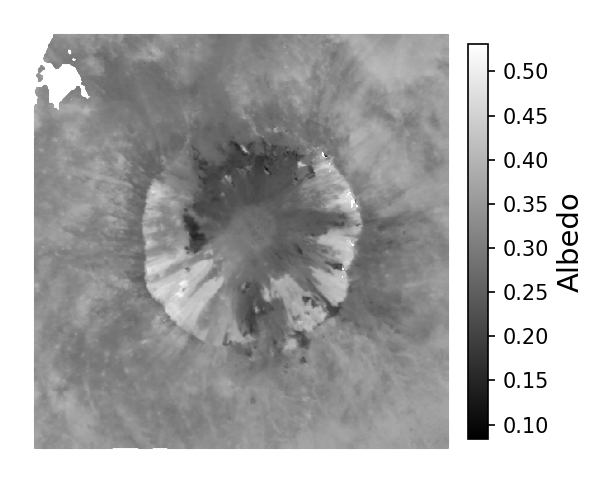

In [3]:
import matplotlib.pyplot as plt

from matplotlib.colors import Normalize


plt.rcParams['figure.dpi'] = 150

# Get albedos and scale.
pcd = np.array([p3d.xyz for p3d in points3d.values()])
alb = np.array([p3d.albedo for p3d in points3d.values()])

# Project into first image. 
R_CA = images[0].qvec2rotmat()
r_AC_C = images[0].tvec[..., None]
fx, fy, cx, cy = cameras[0].params
xyz_C = R_CA @ pcd.T + r_AC_C
x_C = fx * xyz_C[0] / xyz_C[2] + cx
y_C = fy * xyz_C[1] / xyz_C[2] + cy
xy_C = np.vstack((x_C[None, ...], y_C[None, ...]))

# Plot albedo map!
norm = Normalize(np.nanmin(alb), np.nanmax(alb))
sc = plt.scatter(xy_C[0], xy_C[1], s=0.15, c=alb, marker=",", cmap="gray", norm=norm)
cbar = plt.colorbar(sc, orientation="vertical", shrink=0.87, pad=0.0)
cbar.set_label(label=r"Albedo", size=14)
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal")
plt.axis("off")
plt.show()

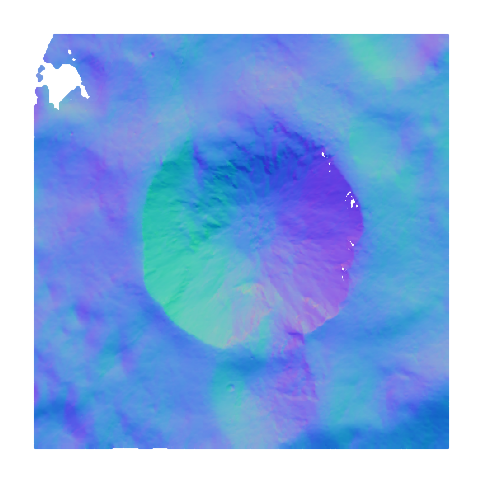

In [4]:
vis_normal = lambda normal: ((normal - np.nanmin(normal[:])) / 2)[..., ::-1]

nvecs = np.array([p3d.nvec for p3d in points3d.values()])

plt.close()
plt.scatter(xy_C[0], xy_C[1], s=0.15, c=vis_normal(nvecs), marker=",")
plt.axis("off")
plt.gca().invert_yaxis()
plt.gca().set_aspect("equal")
plt.show()

# Compare image and rendering

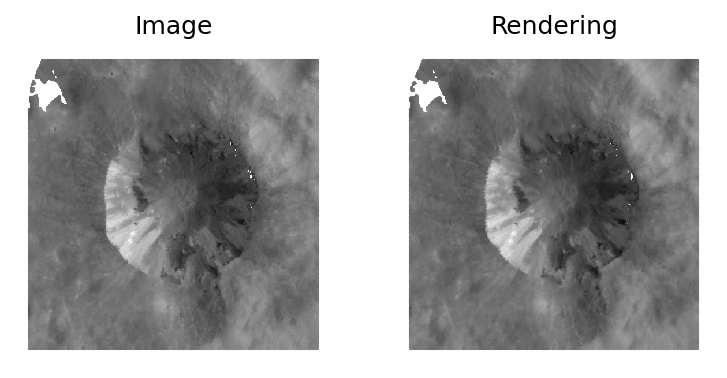

Mean photometric error: 0.010427839547862439


In [5]:
from utils.reflectance import schroder2013_reflectance


image_id = 0

# Compute estimated brightness.
image = images[image_id]
intens_est = np.ones_like(image.intens) * np.nan
for idx, point3d_id in enumerate(image.point3D_ids):
    if point3d_id < 0:
        continue
    p3d = points3d[point3d_id]
    reflect, alpha, beta, phi = schroder2013_reflectance(image.qvec2rotmat(), image.tvec, p3d.xyz, image.svec, p3d.nvec)
    intens_est[idx] = image.scale * p3d.albedo * reflect + image.bias

# Plot measured example.
valid_idxs = ~np.isnan(intens_est)
xys = images[image_id].xys[valid_idxs]
inten = images[image_id].intens[valid_idxs]

plt.subplot(1, 2, 1)
plt.scatter(xys[:, 0], -xys[:, 1] + 1024, s=0.05, c=inten, marker=",", cmap="gray")
plt.gca().set_aspect("equal")
plt.gca().set_title("Image")
plt.axis("off")

# Get xys from forward projected landmarks.
valid_idxs = ~np.isnan(intens_est)
pcd = np.array([points3d[point3d_id].xyz if point3d_id >= 0 and valid_idxs[idx] else np.ones(3) * np.nan for idx, point3d_id in enumerate(images[image_id].point3D_ids)])
R_CA = images[image_id].qvec2rotmat()
r_AC_C = images[image_id].tvec[..., None]

fx, fy, cx, cy = cameras[0].params
xyz_C = R_CA @ pcd.T + r_AC_C
x_C = fx * xyz_C[0] / xyz_C[2] + cx
y_C = fy * xyz_C[1] / xyz_C[2] + cy
xys = np.vstack((x_C[None, ...], y_C[None, ...]))

# Plot estimated example.
plt.subplot(1, 2, 2)
plt.scatter(xys[0], -xys[1] + 1024, s=0.05, c=intens_est, marker=",", cmap="gray")
plt.gca().set_aspect("equal")
plt.gca().set_title("Rendering")
plt.axis("off")
plt.show()

print(
    "Mean photometric error:", 
    np.sqrt(np.mean((inten - intens_est[valid_idxs]) * (inten - intens_est[valid_idxs]))) / np.mean(inten),
)